### Brain MRI segmentation  
- 참고 사이트(1): https://www.kaggle.com/monkira/brain-mri-segmentation-using-unet-keras/data?  
- https://www.slideshare.net/YunhoMaeng/python-api-feat-autoai  
- https://wsyang.com/2011/05/mendels-low-with-statistics/ [유전통계] 통계로 설명하는 멘델의 유전 법칙

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
#Set Parameters
im_width = 256
im_height = 256

# **Load image's path and mask's path**

In [ ]:
train_files = []
mask_files = glob('/content/gdrive/My Drive/Colab Notebooks/deeplearning_practice/TCGA-LGG-Segmentation/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['/content/gdrive/My Drive/Colab Notebooks/deeplearning_practice/TCGA-LGG-Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_8.tif', '/content/gdrive/My Drive/Colab Notebooks/deeplearning_practice/TCGA-LGG-Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_16.tif', '/content/gdrive/My Drive/Colab Notebooks/deeplearning_practice/TCGA-LGG-Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_3.tif', '/content/gdrive/My Drive/Colab Notebooks/deeplearning_practice/TCGA-LGG-Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_13.tif', '/content/gdrive/My Drive/Colab Notebooks/deeplearning_practice/TCGA-LGG-Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6.tif', '/content/gdrive/My Drive/Colab Notebooks/deeplearning_practice/TCGA-LGG-Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_

# Representation in DataFrame

In [ ]:
df_train = pd.DataFrame(train_files)
print(df_train.shape)   # check value
df_train.head()

(3929, 1)


,0
0,/content/gdrive/My Drive/Colab Notebooks/deepl...
1,/content/gdrive/My Drive/Colab Notebooks/deepl...
2,/content/gdrive/My Drive/Colab Notebooks/deepl...
3,/content/gdrive/My Drive/Colab Notebooks/deepl...
4,/content/gdrive/My Drive/Colab Notebooks/deepl...


In [ ]:
df_mask = pd.DataFrame(mask_files)
print(df_mask.shape)
df_mask.head()

(3929, 1)


,0
0,/content/gdrive/My Drive/Colab Notebooks/deepl...
1,/content/gdrive/My Drive/Colab Notebooks/deepl...
2,/content/gdrive/My Drive/Colab Notebooks/deepl...
3,/content/gdrive/My Drive/Colab Notebooks/deepl...
4,/content/gdrive/My Drive/Colab Notebooks/deepl...


file_name: /content/gdrive/My Drive/Colab Notebooks/deeplearning_practice/TCGA-LGG-Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_8.tif
(256, 256, 3)


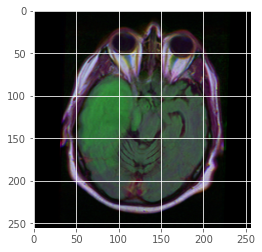

In [ ]:
print("file_name:", train_files[0])
test_train = cv2.imread(train_files[0])
print(test_train.shape)
plt.imshow(test_train)

file_name: /content/gdrive/My Drive/Colab Notebooks/deeplearning_practice/TCGA-LGG-Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_8_mask.tif
(256, 256, 3)


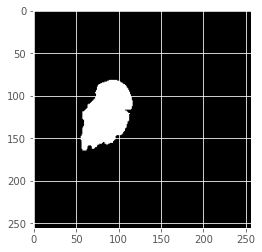

In [ ]:
print("file_name:", mask_files[0])
test_mask = cv2.imread(mask_files[0])
print(test_mask.shape)
plt.imshow(test_mask)

# **Data Visualization**

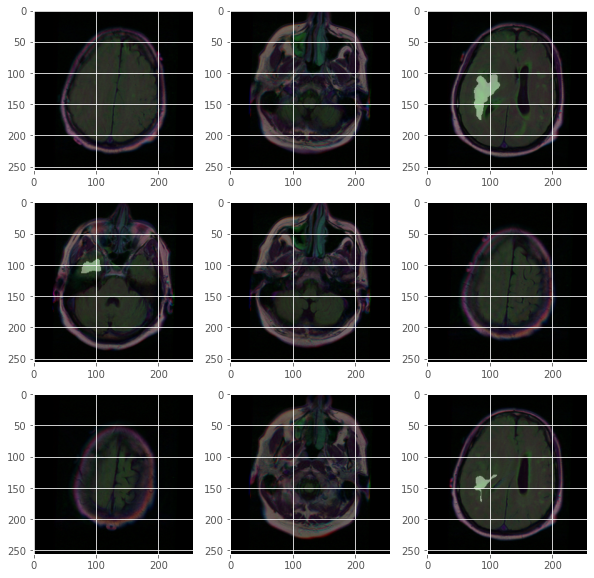

In [ ]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  # openCV default: BGR
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)     # 덮어쓸 영상에 alpha(투명도)값을 정해줘야 아래 영상이 보임
plt.show()    # 캐글에서는 칼라로 나오는데 코랩에서는 흑백인 이유? GPU를 사용하지 않아서 그런 것이였음. 

# **Create data frame and split data on train set, validation set and test set**

### 기계학습 훈련 데이터 구성 방법 
기계 학습으로 분석 모형을 만들기 위해서는 학습을 위한 데이터가 필요합니다. 보통 원래의 전체 데이터 셋에서 두 종류의 데이터로 구분해서 실험을 합니다.
- 학습을 위한 데이터 셋 (training data)  
- 학습된 모델 검증을 위한 테스트용 데이터 셋 (test data)

싸이킷런에서 제공하는 실험 데이터 구성을 지원하는 함수들을 알아보기.  

(1) train_test_split 함수  
- train_test_split 함수는 전체 데이터셋 배열을 받아서 랜덤하게 훈련/테스트 데이터 셋으로 분리해주는 함수입니다. 함수 정의는 아래와 같습니다. 참고로 함수에 대한 자세한 설명은 링크(https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)에서 확인 가능합니다. 
 > from sklearn.model_selection import train_test_split

 > sklearn.model_selection.train_test_split(array*, test_size, train_size, random_state, shuffle, stratify)[source at: https://github.com/scikit-learn/scikit-learn/blob/7389dba/sklearn/model_selection/_split.py#L2073]
 
 필수 인자 값으로는 데이터들을 받게되는데, 데이터 형태로는 list, arrays, matrics, dataframe 등 다양한 형태들이 있다. 클래스 값을 포함하여 하나의 데이터로 받을 수도 있고 클래스 값을 분리해서 두개의 데이터로도 받을 수 있습니다.  
 (1) 클래스 값을 포함하여 하나의 데이터로 받는 경우  
 - df_train, df_test = train_test_split(df, test_size=0.4, random_state=0)

 (2) 클래스를 개별의 배열로 받는 경우
 - train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.5)

> 아래 다른 파라미터들은 다 옵션으로 선택 가능합니다.

> test_size는 float, int 또는 None값을 사용합니다. 0에서 1의 값(float)을 입력하면 전체 데이터 셋에서 test set의 비율을 의미합니다. 0.3을 입력할 경우 전체 데이터의 30%를 랜덤하게 테스트로 사용합니다. 정수 값(int)을 입력하면 데이터 개수를 의미합니다. None을 입력하고 훈련 데이터 셋 사이즈를 지정할 경우 훈련 데이터셋을 뺀 나머지를 테스트 데이터로 사용합니다. 기본 값은 0.25입니다.

> train_size는 float, int 또는 None값을 사용합니다. 0에서 1의 값(float)을 입력하면 전체 데이터 셋에서 train set의 비율을 의미합니다. 0.3을 입력할 경우 전체 데이터의 30%를 랜덤하게 훈련 데이터로 사용합니다. 정수 값(int)을 입력하면 훈련에 사용될 데이터 개수를 의미합니다. None을 입력하고 테스트 데이터 셋 사이즈를 지정할 경우 테스트 데이터셋을 뺀 나머지를 훈련 데이터로 사용합니다. 기본 값은 None입니다.

> random_state는 int, randomstate instance 또는 None 값을 사용합니다. 정수 값을 입력하면 숫자를 random하게 생성할때 사용되는 seed 숫자로 사용되며, None을 입력하면 np.random에서 제공하는 random number generator가 사용됩니다.

> shuffle은 bool 값으로 데이터를 분리하기 전에 데이터를 셖을 것인지 지정하며 기본값은 True이다.

> stratify는 훈련/테스트 데이터들이 원래의 input dataset의 클래스의 비율과 같은 비율을 가지도록 할 것인지 지정한다. 예를 들어 0,1의 클래스가 input dataset에 20:80 비율로 있었다면 훈련 데이터와 테스트 데이터 역시 각각의 클래스가 같은 비율로 있도록 지정할 수 있다. 

이런 식으로 데이터를 비율 등으로 간단하게 데이터를 분리하여 실험 데이터를 구성할 수 있습니다.

In [ ]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df, test_size = 0.1)       # train : 90% VS test : 10%
df_train, df_val = train_test_split(df_train, test_size = 0.2)  # 위에서 총 데이터의 90%를 train 데이터로 나누고, 그 train 데이터의 20%를 validation 데이터로 할당함. 
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


# **Data genertator, data augmentation and adjust data**

In [ ]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255     # 영상의 최대값 255로 나누어서 0에서 1사이 값으로 정규화
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

# **Define loss function and metrics**
(1) Dice  
(2) IOU

> Dice coeffcient 또는 Dice score 
  - Sorensen-Dice coefficient
  - 레이블링된 영역과 예측한 영역이 정확히 같다면, 1이되고, 그렇지 않을 경우에는 0이 됨.
  - F1 score와 같은 개념이며, 조화평균 공식과 같음.  
  - 공식: 
      $$Dice = {2 \times TP \over (TP + FP) + (TP + FN) }$$  

> IOU 공식: 
  $$IOU = {Area \ of \ Overlap \over Area \ of \ Union}$$

In [ ]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And = K.sum(y_truef * y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# **Define Unet**

In [ ]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
_______________________________________________________________________________________

# **Training**

In [ ]:
EPOCHS = 150
BATCH_SIZE = 32
learning_rate = 1e-4

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                            train_generator_args,
                            target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE, dict(),
                             target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))

decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

ckpt_path = '/content/gdrive/My Drive/Colab Notebooks/deeplearning_practice/ckpt/unet_brain_mri_seg.hdf5'
callbacks = [ModelCheckpoint(ckpt_path, verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/150
89/88 [==============================] - ETA: -17s - loss: -0.1665 - binary_accuracy: 0.9396 - iou: 0.0945 - dice_coef: 0.1682Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 00001: val_loss improved from inf to -0.02646, saving model to /content/gdrive/My Drive/Colab Notebooks/deeplearning_practice/ckpt/unet_brain_mri_seg.hdf5
89/88 [==============================] - 3030s 34s/step - loss: -0.1665 - binary_accuracy: 0.9396 - iou: 0.0945 - dice_coef: 0.1682 - val_loss: -0.0265 - val_binary_accuracy: 0.9898 - val_iou: 0.0130 - val_dice_coef: 0.0255
Epoch 2/150
89/88 [==============================] - ETA: 0s - loss: -0.2967 - binary_accuracy: 0.9887 - iou: 0.1767 - dice_coef: 0.2960
Epoch 00002: val_loss did not improve from -0.02646
89/88 [==============================] - 67s 752ms/step - loss: -0.2967 - binary_accuracy: 0.9887 - iou: 0.1767 - dice_coef: 0.2960 - val

In [ ]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [ ]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()